Import libraries

In [ ]:
import infotopo_no_prints
import os
import xgi
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.animation as animation
from sklearn.utils import Bunch
from scipy.integrate import solve_ivp
from mpl_toolkits.mplot3d import Axes3D

import mne
import pandas as pd
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Define functions

In [ ]:
# Normalize the first two columns individually for a given dataframe (range 0-1)
def normalize_columns(df):
    # Normalize first column (index 0)
    min_x, max_x = df.iloc[:, 0].min(), df.iloc[:, 0].max()
    df.iloc[:, 0] = (df.iloc[:, 0] - min_x) / (max_x - min_x) if max_x != min_x else 0
    
    # Normalize second column (index 1)
    min_y, max_y = df.iloc[:, 1].min(), df.iloc[:, 1].max()
    df.iloc[:, 1] = (df.iloc[:, 1] - min_y) / (max_y - min_y) if max_y != min_y else 0
    
    return df

# Optimized function to compute TSE complexity
def compute_tse_complexity(TC_dict):
    """
    Computes the TSE complexity given a dictionary of total correlations.
    
    Parameters:
        TC_dict (dict): Dictionary of total correlations where keys are tuples (subsets).
        
    Returns:
        float: The TSE complexity.
    """
    N = max(len(subset) for subset in TC_dict)  # Maximum subset size
    TSE = 0
    for gamma in range(1, N):
        TC_full = (gamma / N) * TC_dict[tuple(range(1, N + 1))]
        E_TC_gamma = np.mean([TC_dict[subset] for subset in TC_dict if len(subset) == gamma])
        TSE += TC_full - E_TC_gamma
    return TSE

# Convert pandas dataframe to bunch object
def dataframe_to_bunch(dataframe, target=None, feature_names=None, target_names=None, descr="Custom dataset"):
    if feature_names is None:
        feature_names = dataframe.columns.tolist()
    
    return Bunch(
        data=dataframe.to_numpy(),
        target=target if target is not None else np.zeros(dataframe.shape[0]),
        feature_names=feature_names,
        target_names=target_names if target_names is not None else ["target"],
        DESCR=descr
    )

# Obtain topological information metrics using infotopo
def obtain_infotopo_metrics(dataset, dimension_max=0, dimension_tot=0):

    if dimension_max == 0:
        dimension_max = 3 #dataset.shape[1]
    if dimension_tot == 0:
        dimension_tot = 9 #dataset.shape[1]
    
    sample_size = dataset.shape[0]
    nb_of_values = 16
    forward_computation_mode = True
    work_on_transpose = False
    supervised_mode = False
    sampling_mode = 1
    deformed_probability_mode = False

    information_topo = infotopo_no_prints.infotopo(dimension_max = dimension_max,
                                dimension_tot = dimension_tot,
                                sample_size = sample_size,
                                work_on_transpose = work_on_transpose,
                                nb_of_values = nb_of_values,
                                sampling_mode = sampling_mode,
                                deformed_probability_mode = deformed_probability_mode,
                                supervised_mode = supervised_mode,
                                forward_computation_mode = forward_computation_mode)
    
    Nentropie = information_topo.simplicial_entropies_decomposition(dataset)
    Ninfomut = information_topo.simplicial_infomut_decomposition(Nentropie)
    Nfree_energy = information_topo.total_correlation_simplicial_lanscape(Nentropie)
    
    return  Nentropie, Ninfomut, Nfree_energy


Visualize timeseries of one subject to understand the data

Using matplotlib as 2D backend.


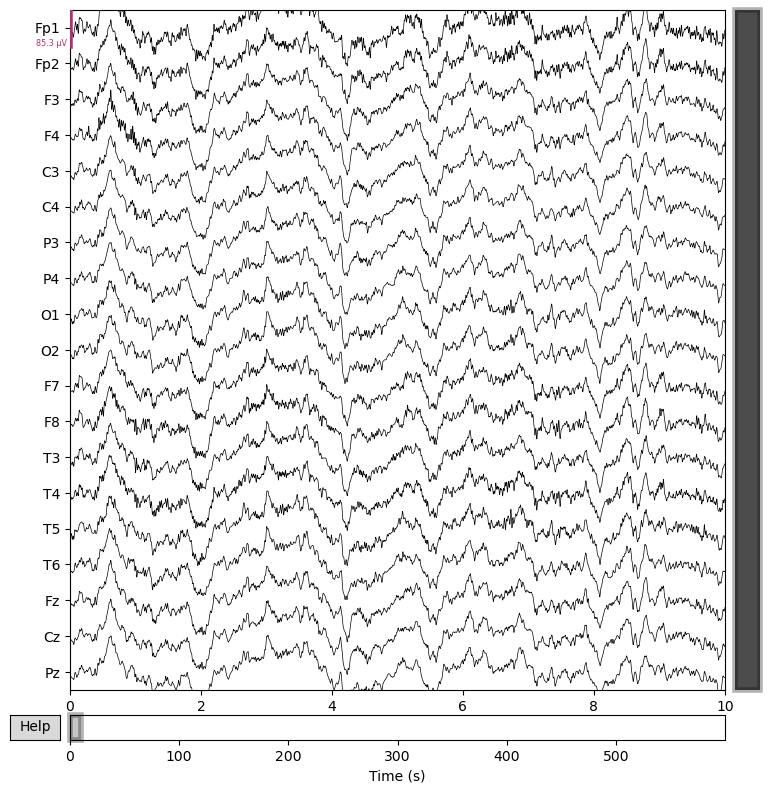

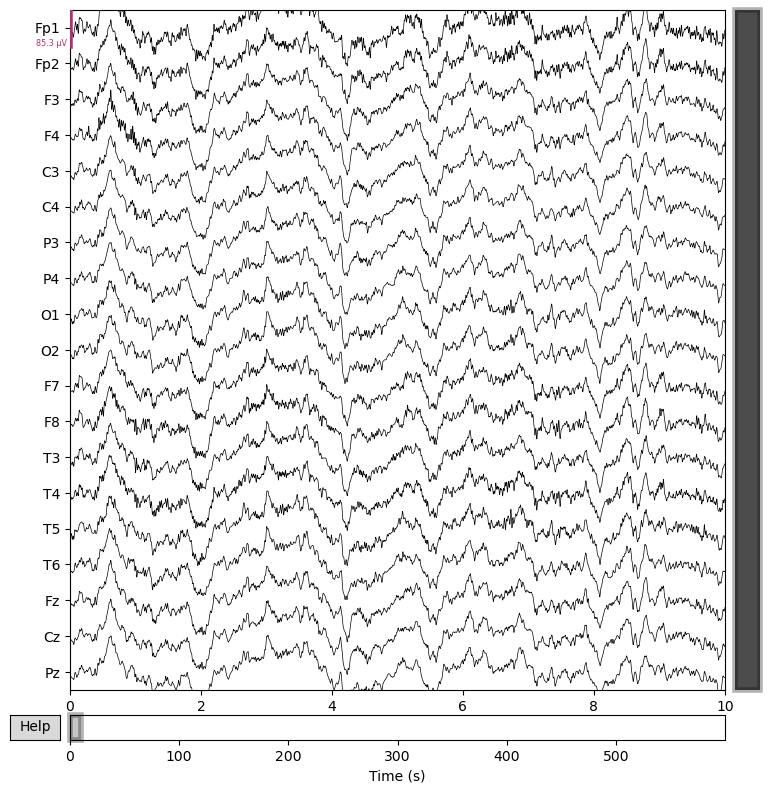

In [ ]:
file_path = 'Data\\sub-001_task-eyesclosed_eeg.set'
raw = mne.io.read_raw_eeglab(file_path, preload=True)
raw.plot(title='Raw EEG Signal', duration=10, n_channels=19, scalings='auto')

Single file to explore computational speed

In [62]:
# Set initial conditions
dimension_max = 5
dimension_tot = 19
length_data_file = 100

# Folder containing EEG data files
folder_path = 'Data\\EEG_brain_test\\sub-001_task-eyesclosed_eeg.set'

############## IMPORT THE DATA #############
# Load EEG data
raw = mne.io.read_raw_eeglab(file_path, preload=True)

# Get data and times from all channels
data, times = raw.get_data(return_times=True)  # data shape: (n_channels, n_times)

# Create DataFrame: rows = time points, columns = channel names
df_EEG = pd.DataFrame(data.T, columns=raw.ch_names)  # transpose so shape = (n_times, n_channels)
df_EEG['Time (s)'] = times

# Optional: Set 'Time (s)' as the index
df_EEG.set_index('Time (s)', inplace=True)

############## COMPUTE INFORMATION METRICS ##
# Obtain information metrics
bunch_data = dataframe_to_bunch(df_EEG[:length_data_file])
Nentropie, Ninfomut, Nfree_energy = obtain_infotopo_metrics(bunch_data.data, dimension_max, dimension_tot)

S_values = [(TC - MI) / 2 for TC, MI in zip(Nfree_energy.values(), Ninfomut.values())]
R_values = [(TC + MI) / 2 for TC, MI in zip(Nfree_energy.values(), Ninfomut.values())]
S_sum = sum(S_values)
R_sum = sum(R_values)
TSE_value = compute_tse_complexity(Nfree_energy)

C:\Users\cyril\AppData\Local\Temp\ipykernel_1484\4075602740.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)
C:\Users\cyril\AppData\Local\Temp\ipykernel_1484\4075602740.py:25: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  bunch_data = dataframe_to_bunch(df_EEG[:length_data_file])


KeyboardInterrupt: 

Full dataset

In [ ]:
# Set initial conditions
dimension_max = 5
dimension_tot = 5
length_data_file = 100

# Folder containing EEG data files
folder_path = 'Data\\EEG_brain_test\\'
file_list = glob.glob(os.path.join(folder_path, '*.set'))
df = pd.DataFrame(columns=['TSE', 'S', 'R'])

# Loop through all files in the folder
for index, file_path in enumerate(file_list):

    ############## IMPORT THE DATA #############
    # Load EEG data
    raw = mne.io.read_raw_eeglab(file_path, preload=True)

    # Get data and times from all channels
    data, times = raw.get_data(return_times=True)  # data shape: (n_channels, n_times)

    # Create DataFrame: rows = time points, columns = channel names
    df_EEG = pd.DataFrame(data.T, columns=raw.ch_names)  # transpose so shape = (n_times, n_channels)
    df_EEG['Time (s)'] = times

    # Optional: Set 'Time (s)' as the index
    df_EEG.set_index('Time (s)', inplace=True)

    ############## COMPUTE INFORMATION METRICS ##
    # Obtain information metrics
    bunch_data = dataframe_to_bunch(df_EEG[:length_data_file])
    Nentropie, Ninfomut, Nfree_energy = obtain_infotopo_metrics(bunch_data.data, dimension_max, dimension_tot)

    S_values = [(TC - MI) / 2 for TC, MI in zip(Nfree_energy.values(), Ninfomut.values())]
    R_values = [(TC + MI) / 2 for TC, MI in zip(Nfree_energy.values(), Ninfomut.values())]
    S_sum = sum(S_values)
    R_sum = sum(R_values)
    TSE_value = compute_tse_complexity(Nfree_energy)

    df.loc[index, ['TSE', 'S', 'R']] = [TSE_value, S_sum, R_sum]

df.to_csv('Data\\EEG_brain_test\\participant_data_information_metrics.csv', index=False)

C:\Users\cyril\AppData\Local\Temp\ipykernel_1484\875087471.py:34: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  bunch_data = dataframe_to_bunch(df_EEG[:length_data_file])
C:\Users\cyril\AppData\Local\Temp\ipykernel_1484\875087471.py:34: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  bunch_data = dataframe_to_bunch(df_EEG[:length_data_file])
C:\Users\cyril\AppData\Local\Temp\ipykernel_1484\875087471.py:20: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_path, preload=True)
C:\Users\cyril\AppData\Local\Temp\ipykernel_1484\875087471.

Visualize results

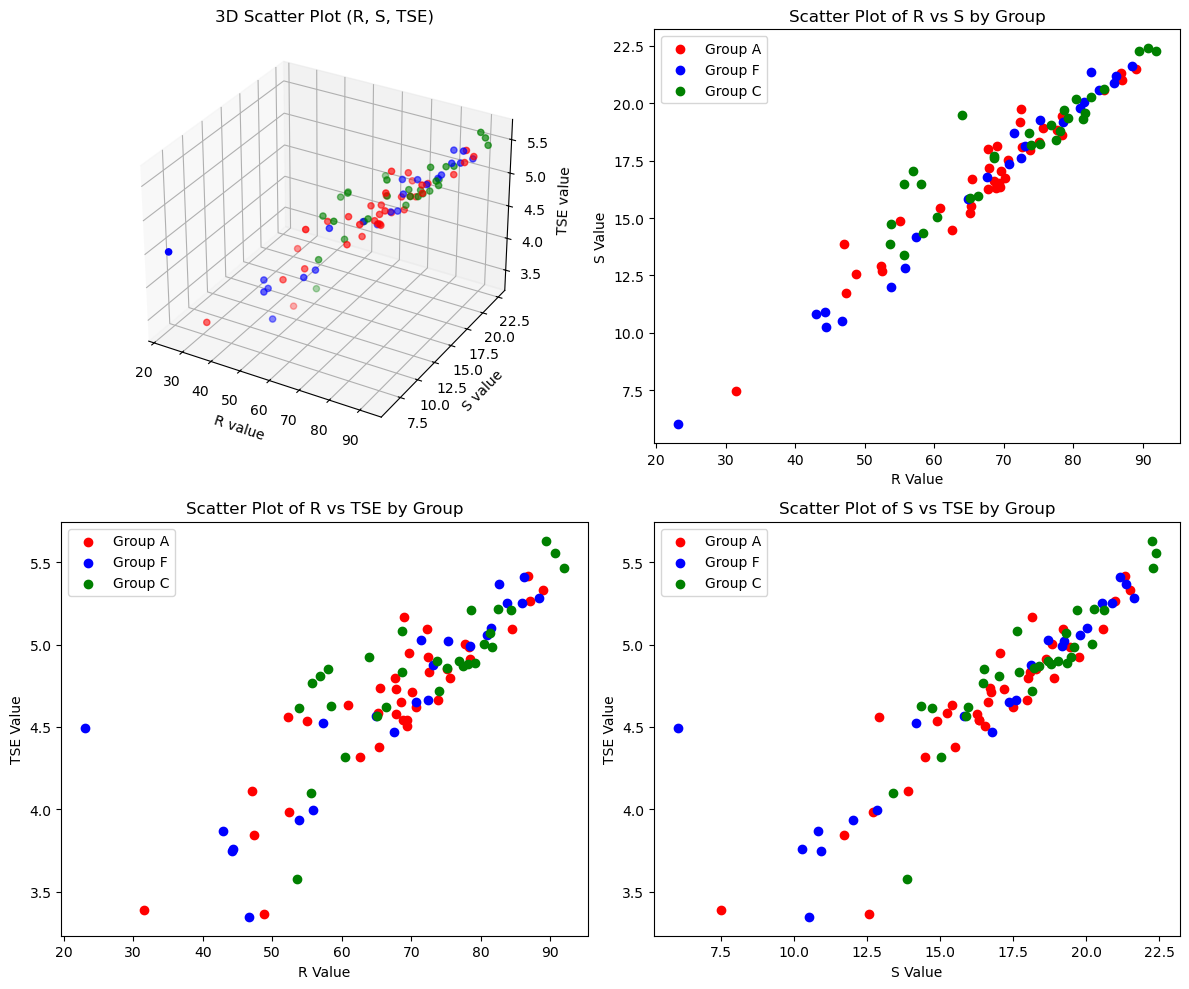

In [ ]:
# Load the data
df = pd.read_csv('Data\\EEG_brain_test\\participant_data_information_metrics.csv')  # F dementia, A alzheimer, C healthy

# Create a figure with 2x2 subplots
fig = plt.figure(figsize=(12, 10))

# Separate the data by Group
group_A = df[df['Group'] == 'A']
group_F = df[df['Group'] == 'F']
group_C = df[df['Group'] == 'C']

# Create the 3D plot (top-left)
ax1 = fig.add_subplot(221, projection='3d')
colors = df['Group'].map({'A': 'red', 'F': 'blue', 'C': 'green'})
ax1.scatter(df['R'], df['S'], df['TSE'], c=colors)
ax1.set_xlabel('R value')
ax1.set_ylabel('S value')
ax1.set_zlabel('TSE value')
ax1.set_title('3D Scatter Plot (R, S, TSE)')

# Create the 2D scatter plots (the other three plots)
# Scatter plot of R vs S (top-right)
ax2 = fig.add_subplot(222)
ax2.scatter(group_A['R'], group_A['S'], color='red', label='Alzheimer')
ax2.scatter(group_F['R'], group_F['S'], color='blue', label='Frontotemporal Dementia')
ax2.scatter(group_C['R'], group_C['S'], color='green', label='Healthy')
ax2.set_xlabel('R Value')
ax2.set_ylabel('S Value')
ax2.set_title('Scatter Plot of R vs S by Group')
ax2.legend()

# Scatter plot of R vs TSE (bottom-left)
ax3 = fig.add_subplot(223)
ax3.scatter(group_A['R'], group_A['TSE'], color='red', label='Alzheimer')
ax3.scatter(group_F['R'], group_F['TSE'], color='blue', label='Frontotemporal Dementia')
ax3.scatter(group_C['R'], group_C['TSE'], color='green', label='Healthy')
ax3.set_xlabel('R Value')
ax3.set_ylabel('TSE Value')
ax3.set_title('R vs TSE by Group')
ax3.legend()

# Scatter plot of S vs TSE (bottom-right)
ax4 = fig.add_subplot(224)
ax4.scatter(group_A['S'], group_A['TSE'], color='red', label='Alzheimer')
ax4.scatter(group_F['S'], group_F['TSE'], color='blue', label='Frontotemporal Dementia')
ax4.scatter(group_C['S'], group_C['TSE'], color='green', label='Healthy')
ax4.set_xlabel('S Value')
ax4.set_ylabel('TSE Value')
ax4.set_title('S vs TSE by Group')
ax4.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()
